# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = False
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 8
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2495 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

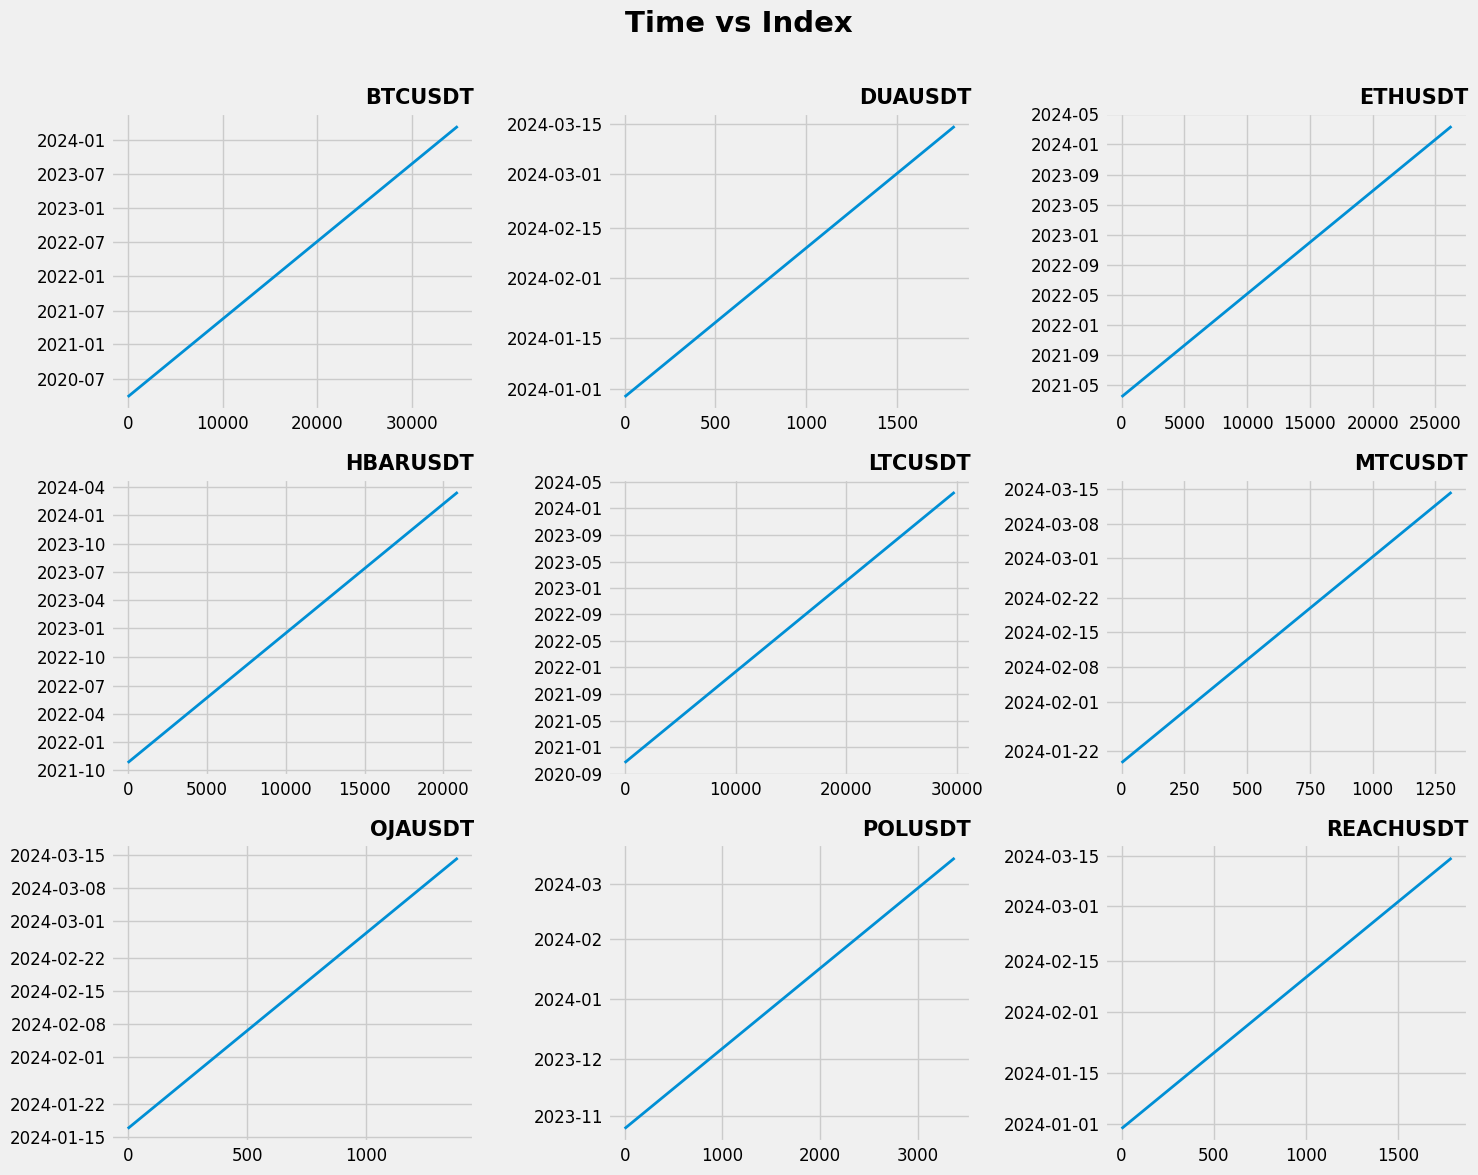

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel('')
        plt.yticks(fontsize=12) 
        ax.set_xlabel('')
        plt.xticks(fontsize=12)
        # ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, '', '', 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ['close', 'btcd_close', 'btcdom_close']:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f'{col}_{agg_func.__name__}_{period}'] = df[col].rolling(period, min_periods=1).agg({'func': agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 16, 17, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [1, 4, 14, 16, 17, 18, 19, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

    display(train_sell.head())
    display(train_sell.shape)

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if 'prev' not in c and 'sar' in c]


# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)

    agg_funcs = ['amin', 'amax', 'mean', 'median', 'std']
    agg_cols = [c for c in cols if len(c.split('_')) > 2 and c.split('_')[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ['atr', 'cci', 'sar', 'volume', 'pattern', 'target', 'ticker', 'ttype'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
prev_ticker = None

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,702,1256,0.558917,"(0.5316, 0.5862)"
3,1,1,860,1610,0.534161,"(0.5099, 0.5584)"
5,2,1,810,1526,0.530799,"(0.5059, 0.5557)"
7,3,1,935,1794,0.521182,"(0.4982, 0.5442)"
9,16,1,768,1411,0.544295,"(0.5184, 0.5701)"
11,17,1,748,1440,0.519444,"(0.4938, 0.5451)"
13,21,1,804,1481,0.542876,"(0.5176, 0.5681)"
15,22,1,832,1492,0.557641,"(0.5326, 0.5827)"
17,23,1,726,1282,0.566303,"(0.5393, 0.5933)"


buy    13292
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7185
0       STOCH_RSI_Volume24    6107
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.540551
0       STOCH_RSI_Volume24    0.459449
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,485,930,0.521505,"(0.4896, 0.5534)"
3,4,1,766,1437,0.533055,"(0.5074, 0.5587)"
5,14,1,745,1384,0.538295,"(0.5122, 0.5644)"
7,16,1,600,1135,0.528634,"(0.4997, 0.5575)"
9,17,1,532,941,0.565356,"(0.5338, 0.5969)"
11,18,1,474,893,0.530795,"(0.4982, 0.5634)"
13,19,1,489,905,0.540331,"(0.508, 0.5726)"
15,21,1,524,952,0.550420,"(0.519, 0.5819)"
17,22,1,476,895,0.531844,"(0.4993, 0.5644)"
19,23,1,524,943,0.555673,"(0.5241, 0.5872)"


sell    10415
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    5615
0       STOCH_RSI_Volume24    4800
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.539126
0       STOCH_RSI_Volume24    0.460874
dtype: float64

# Data visualization

### Plot ratio of class 1 for every month

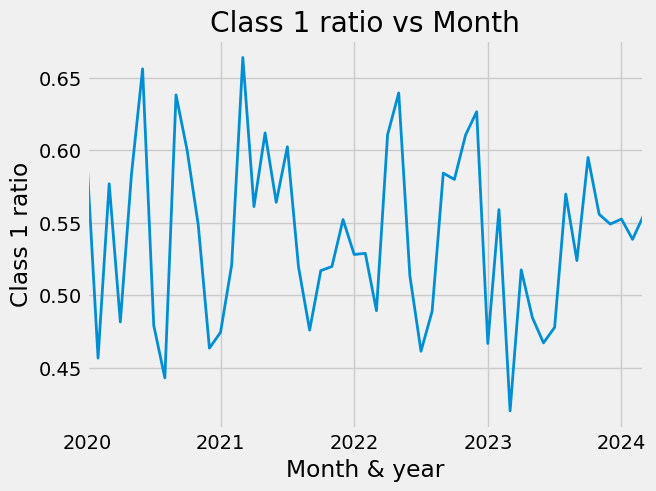

In [14]:
train_df['date_month'] = train_df['time'].dt.to_period('M')
group_df = train_df[train_df['time'].dt.year >= 2020]
ax = group_df.groupby('date_month')['target'].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel('Month & year')
ax.set_ylabel('Class 1 ratio')
ax.set_title('Class 1 ratio vs Month')
train_df = train_df.drop(columns='date_month')

### Visualize buy trades

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [16]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

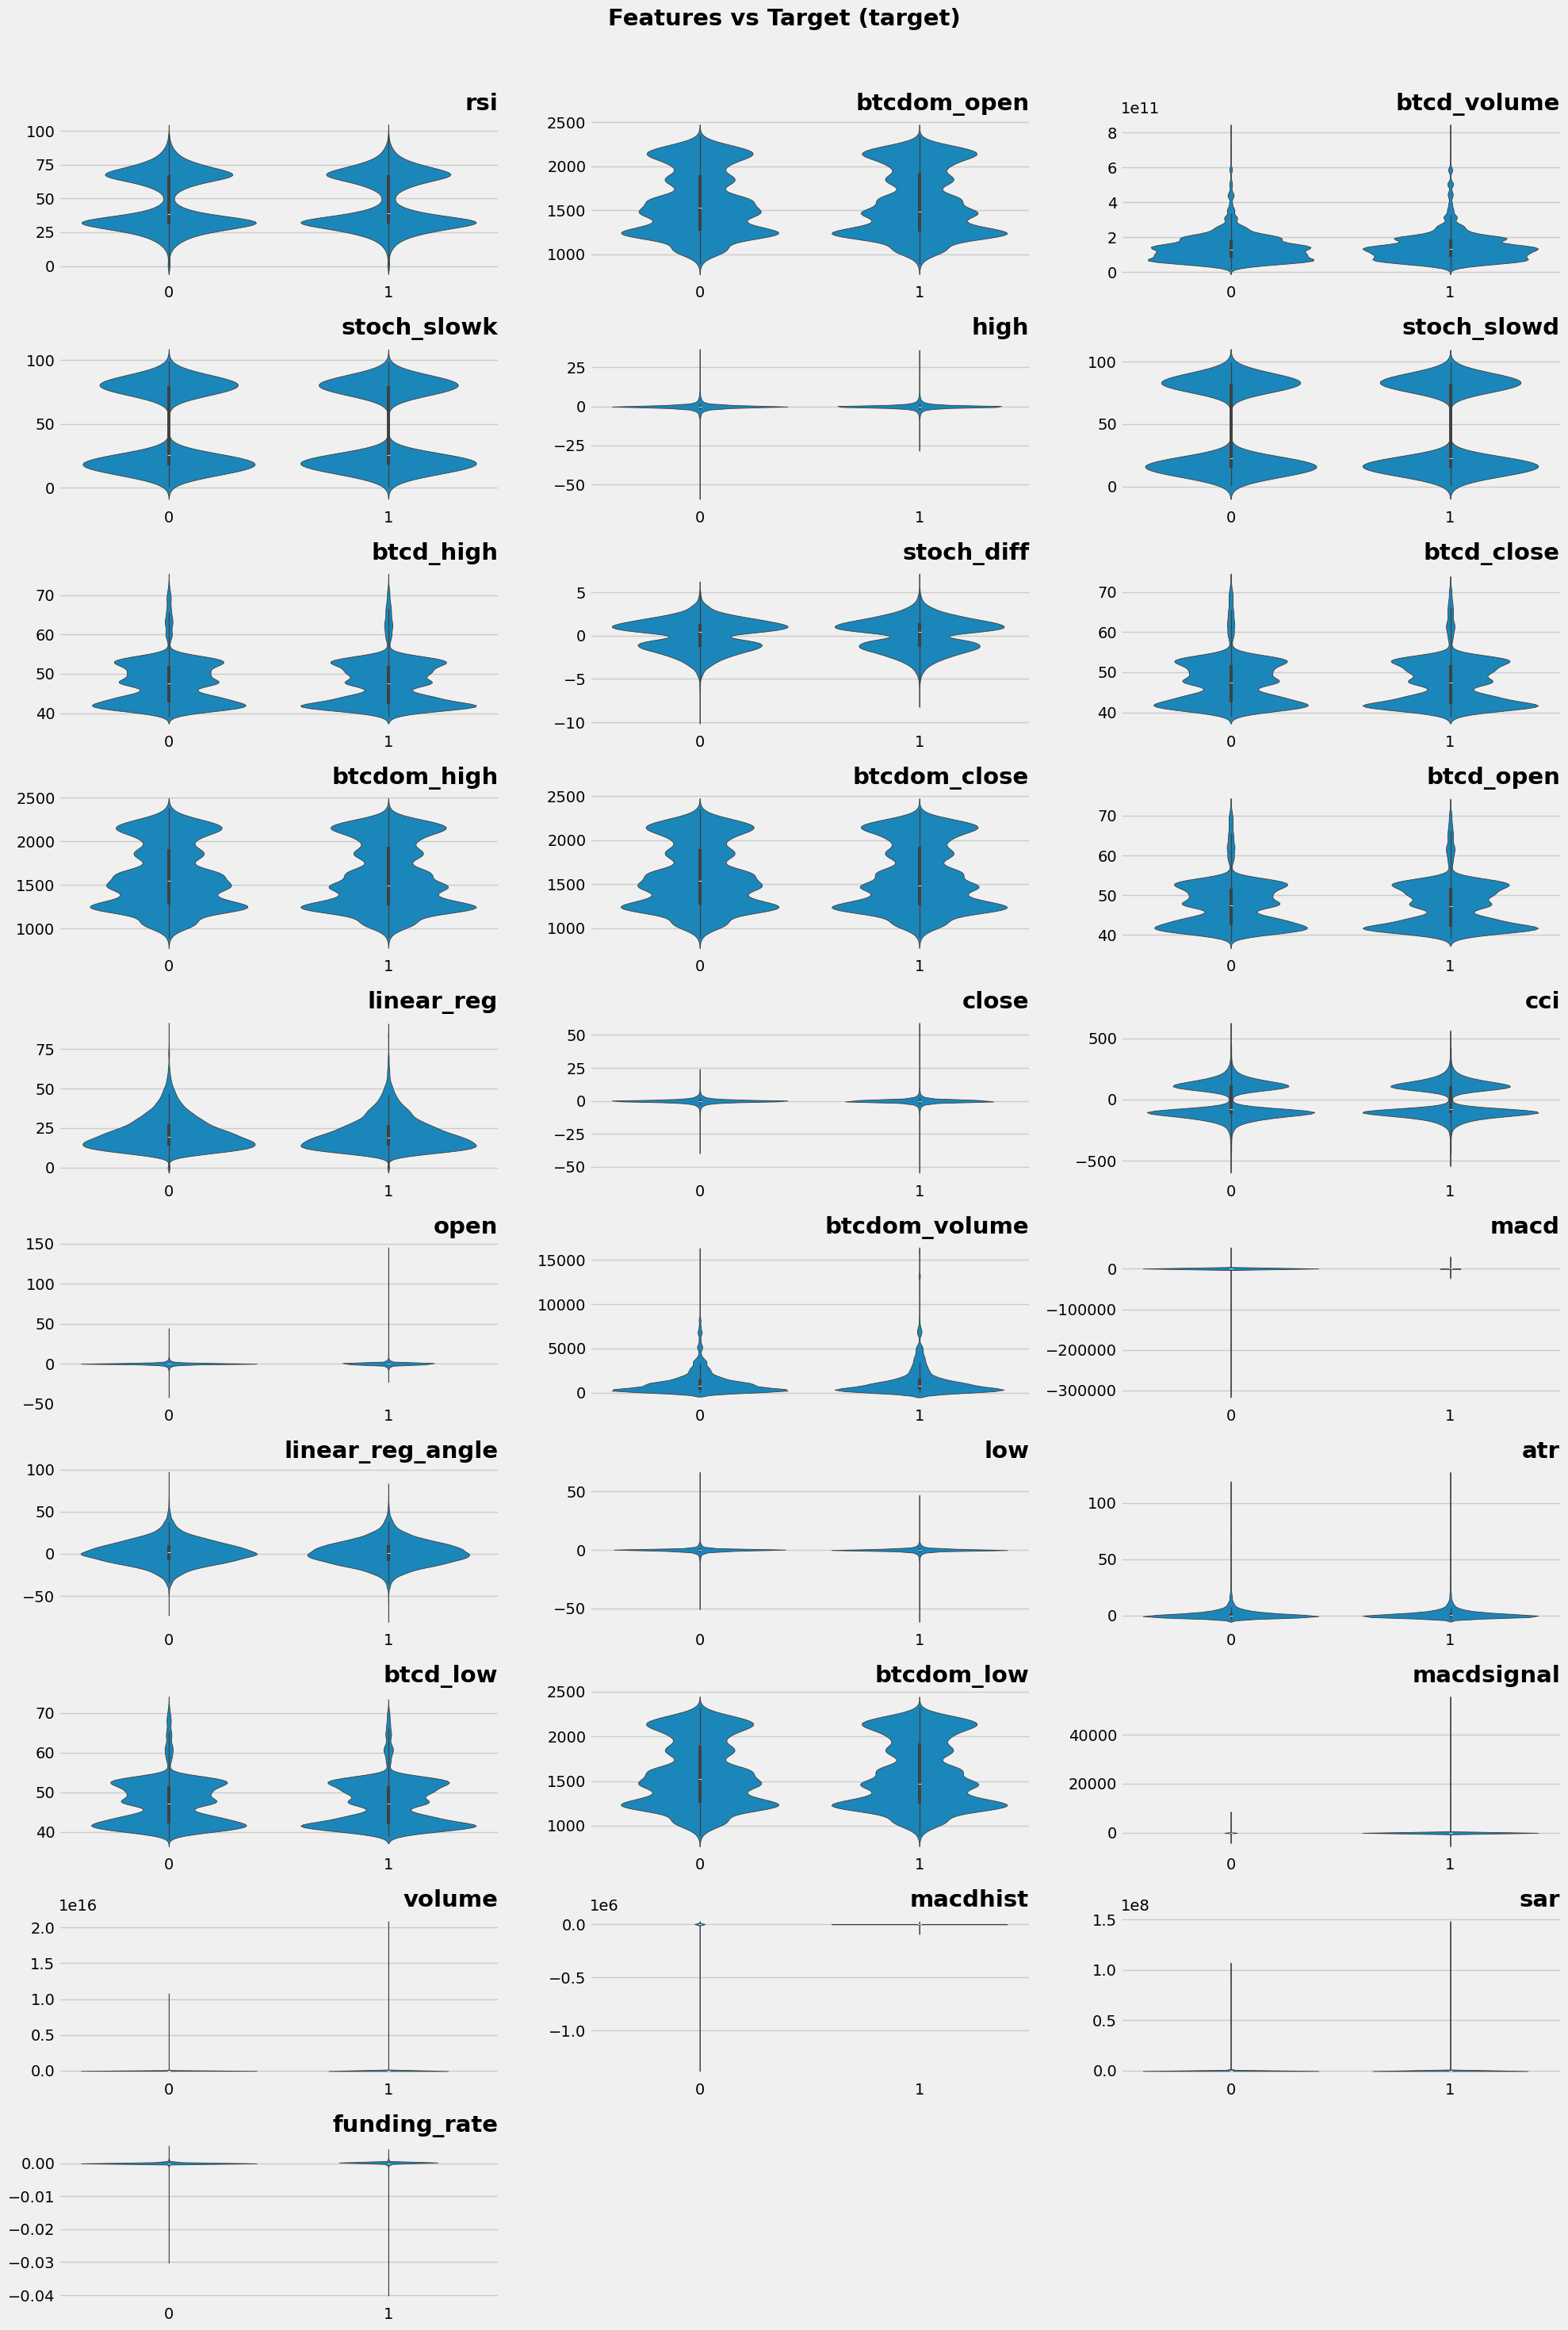

In [17]:
fi = pd.read_csv(f'model/feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target')

### Show the last signals

In [18]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(35)

,time,ticker,ttype,pattern
75790,2024-03-14 01:00:00,CTXCUSDT,buy,STOCH_RSI_Volume24
75791,2024-03-14 02:00:00,ROGUSDT,sell,STOCH_RSI_Volume24
75792,2024-03-14 03:00:00,BCUTUSDT,sell,STOCH_RSI_Volume24
75793,2024-03-14 03:00:00,FDUSDUSDT,sell,STOCH_RSI_Volume24
75794,2024-03-14 03:00:00,XWGUSDT,sell,STOCH_RSI_Volume24
75795,2024-03-14 03:00:00,XAVAUSDT,sell,STOCH_RSI_Volume24
75796,2024-03-14 03:00:00,SCPTUSDT,sell,STOCH_RSI_Volume24
75797,2024-03-14 04:00:00,SOLUSDT,sell,STOCH_RSI_Volume24
75798,2024-03-14 04:00:00,JUP_USDT,sell,STOCH_RSI_Volume24
75799,2024-03-14 04:00:00,ERTHAUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [19]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric='logloss', 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [20]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [22]:
if CFG.select_features:
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],
                    boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'model/feature_importance.csv')
else:
    fi = pd.read_csv(f'model/feature_importance.csv')

# Train

### Load selected features

In [23]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['corr', 'rank'], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations['corr'] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit() and period[-2] == 'prev':
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    features = list(features) + ['weekday']
    
    # remove highly correlated features from the feature dict
    feature_dict['features'] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f'{f}_prev_{item[0]}'
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

corr_thresh = 0.5549523759058107
train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv('model/feature_importance.csv')
feature_num = 86
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features)

['rsi',
 'btcdom_open',
 'high',
 'btcdom_volume_prev_8',
 'btcdom_volume_prev_20',
 'high_prev_32',
 'btcdom_volume_prev_44',
 'btcd_volume_prev_48',
 'stoch_diff_prev_52',
 'btcdom_volume_prev_64',
 'low_prev_68',
 'high_prev_68',
 'btcdom_volume_prev_80',
 'high_prev_80',
 'low_prev_88',
 'low_prev_92',
 'btcdom_volume_prev_96',
 'stoch_diff_prev_112',
 'btcdom_volume_prev_116',
 'btcdom_volume_prev_124',
 'stoch_slowk_prev_124',
 'btcdom_volume_prev_132',
 'btcdom_volume_prev_140',
 'rsi_prev_140',
 'stoch_diff_prev_140',
 'btcdom_volume_prev_160',
 'stoch_diff_prev_160',
 'open_prev_168',
 'rsi_prev_172',
 'stoch_diff_prev_172',
 'btcdom_volume_prev_180',
 'atr_prev_180',
 'btcdom_volume_prev_192',
 'close_prev_196',
 'btcdom_volume_prev_208',
 'cci_prev_208',
 'macdhist_prev_212',
 'close_prev_212',
 'cci_prev_224',
 'stoch_diff_prev_224',
 'low_prev_224',
 'btcdom_volume_prev_228',
 'btcdom_volume_prev_248',
 'cci_prev_248',
 'btcdom_volume_prev_260',
 'cci_prev_268',
 'cci_prev

### Functions for train and optimization

In [45]:
val_idxs = list()
prec_score_list = list()
with open(f'model/bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            prec_score_list.append(prec_score)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * prec_score -  1) * prec_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                   
        'verbose': -1,
        'importance_type': 'gain',
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'corr_thresh': trial.suggest_float('corr_thresh', 0.5, 0.99)
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']

    corr_thresh = params['corr_thresh']
    del params['corr_thresh']
    
    fi = pd.read_csv(f'model/feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna/optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna/optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [62]:
params = {
            'boosting_type': 'goss',
            'n_estimators': 1554,
            'learning_rate': 0.00015489490937759868,
            'is_unbalance': True,
            'class_weight': 'balanced',
            'colsample_bytree': 0.8990308862701966,
            # 'subsample': 0.40571361458738814,
            'max_depth': 4,
            'num_leaves': 113,
            'max_bin': 32,
            'reg_alpha': 0.0003033438829907468,
            'reg_lambda': 0.015719271087358405,
            'subsample_freq': 1,
            'objective': 'binary',
            'importance_type': 'gain',
            'metric': 'average_precision',
            'verbosity': -1
        }

train_test = 'fold' # fold, full
high_bound = 0.4995
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna/optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna/optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)

    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_prec_score - 1) * oof_conf_obj_num)}')
elif train_test == 'full': 
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'model/lgbm.pkl') 
    # save feature dictionary for further inference
    with open(f'model/features.json', 'w') as f:
        json.dump(feature_dict, f)

Training with 50 features
Fold #1


1    0.539451
0    0.460549
Name: target, dtype: float64

Timestamp('2022-07-21 21:00:00')

Timestamp('2024-03-13 18:00:00')

[100]	training's binary_logloss: 0.692048	training's average_precision: 0.66289	valid_1's binary_logloss: 0.693369	valid_1's average_precision: 0.541705
[200]	training's binary_logloss: 0.690967	training's average_precision: 0.66885	valid_1's binary_logloss: 0.693414	valid_1's average_precision: 0.545725
[300]	training's binary_logloss: 0.689923	training's average_precision: 0.670985	valid_1's binary_logloss: 0.693473	valid_1's average_precision: 0.545246
[400]	training's binary_logloss: 0.688907	training's average_precision: 0.671971	valid_1's binary_logloss: 0.693551	valid_1's average_precision: 0.544105
[500]	training's binary_logloss: 0.687912	training's average_precision: 0.673547	valid_1's binary_logloss: 0.693579	valid_1's average_precision: 0.543725
[600]	training's binary_logloss: 0.686944	training's average_precision: 0.674111	valid_1's binary_logloss: 0.693682	valid_1's average_precision: 0.543719
[700]	training's binary_logloss: 0.685995	training's average_precision: 0.6746

1    0.544087
0    0.455913
Name: target, dtype: float64

Timestamp('2022-10-19 16:00:00')

Timestamp('2024-03-13 18:00:00')

[100]	training's binary_logloss: 0.692173	training's average_precision: 0.663195	valid_1's binary_logloss: 0.692919	valid_1's average_precision: 0.56538
[200]	training's binary_logloss: 0.691222	training's average_precision: 0.665649	valid_1's binary_logloss: 0.692702	valid_1's average_precision: 0.568299
[300]	training's binary_logloss: 0.690293	training's average_precision: 0.667495	valid_1's binary_logloss: 0.692464	valid_1's average_precision: 0.568117
[400]	training's binary_logloss: 0.689388	training's average_precision: 0.668195	valid_1's binary_logloss: 0.692252	valid_1's average_precision: 0.567693
[500]	training's binary_logloss: 0.688492	training's average_precision: 0.668681	valid_1's binary_logloss: 0.692034	valid_1's average_precision: 0.569493
[600]	training's binary_logloss: 0.687613	training's average_precision: 0.668453	valid_1's binary_logloss: 0.69184	valid_1's average_precision: 0.569723
[700]	training's binary_logloss: 0.686757	training's average_precision: 0.6684

1    0.539116
0    0.460884
Name: target, dtype: float64

Timestamp('2023-02-13 04:00:00')

Timestamp('2024-03-13 18:00:00')

[100]	training's binary_logloss: 0.692361	training's average_precision: 0.650796	valid_1's binary_logloss: 0.693027	valid_1's average_precision: 0.561627
[200]	training's binary_logloss: 0.691592	training's average_precision: 0.652065	valid_1's binary_logloss: 0.692957	valid_1's average_precision: 0.561278
[300]	training's binary_logloss: 0.69083	training's average_precision: 0.655471	valid_1's binary_logloss: 0.692922	valid_1's average_precision: 0.560787
[400]	training's binary_logloss: 0.690097	training's average_precision: 0.656507	valid_1's binary_logloss: 0.69289	valid_1's average_precision: 0.560721
[500]	training's binary_logloss: 0.68938	training's average_precision: 0.657667	valid_1's binary_logloss: 0.692915	valid_1's average_precision: 0.561687
[600]	training's binary_logloss: 0.688674	training's average_precision: 0.65846	valid_1's binary_logloss: 0.692904	valid_1's average_precision: 0.561618
[700]	training's binary_logloss: 0.687992	training's average_precision: 0.659075

1    0.547158
0    0.452842
Name: target, dtype: float64

Timestamp('2023-04-28 01:00:00')

Timestamp('2024-03-13 18:00:00')

[100]	training's binary_logloss: 0.692273	training's average_precision: 0.662635	valid_1's binary_logloss: 0.693159	valid_1's average_precision: 0.569418
[200]	training's binary_logloss: 0.691425	training's average_precision: 0.662894	valid_1's binary_logloss: 0.693213	valid_1's average_precision: 0.569228
[300]	training's binary_logloss: 0.690604	training's average_precision: 0.663272	valid_1's binary_logloss: 0.693273	valid_1's average_precision: 0.569031
[400]	training's binary_logloss: 0.689801	training's average_precision: 0.66383	valid_1's binary_logloss: 0.693337	valid_1's average_precision: 0.568678
[500]	training's binary_logloss: 0.689016	training's average_precision: 0.663977	valid_1's binary_logloss: 0.693405	valid_1's average_precision: 0.568174
[600]	training's binary_logloss: 0.688238	training's average_precision: 0.66451	valid_1's binary_logloss: 0.693502	valid_1's average_precision: 0.567403
[700]	training's binary_logloss: 0.687464	training's average_precision: 0.6657

1    0.573641
0    0.426359
Name: target, dtype: float64

Timestamp('2023-07-11 16:00:00')

Timestamp('2024-03-13 18:00:00')

[100]	training's binary_logloss: 0.692285	training's average_precision: 0.655065	valid_1's binary_logloss: 0.69332	valid_1's average_precision: 0.597838
[200]	training's binary_logloss: 0.691436	training's average_precision: 0.654695	valid_1's binary_logloss: 0.693487	valid_1's average_precision: 0.598688
[300]	training's binary_logloss: 0.690626	training's average_precision: 0.656974	valid_1's binary_logloss: 0.693664	valid_1's average_precision: 0.599514
[400]	training's binary_logloss: 0.689824	training's average_precision: 0.659433	valid_1's binary_logloss: 0.693862	valid_1's average_precision: 0.599715
[500]	training's binary_logloss: 0.689044	training's average_precision: 0.661199	valid_1's binary_logloss: 0.694056	valid_1's average_precision: 0.602292
[600]	training's binary_logloss: 0.688287	training's average_precision: 0.661571	valid_1's binary_logloss: 0.694387	valid_1's average_precision: 0.60559
[700]	training's binary_logloss: 0.687561	training's average_precision: 0.6615

1    0.576351
0    0.423649
Name: target, dtype: float64

Timestamp('2023-09-30 03:00:00')

Timestamp('2024-03-13 18:00:00')

[100]	training's binary_logloss: 0.692429	training's average_precision: 0.643347	valid_1's binary_logloss: 0.693365	valid_1's average_precision: 0.600034
[200]	training's binary_logloss: 0.691718	training's average_precision: 0.644076	valid_1's binary_logloss: 0.693568	valid_1's average_precision: 0.60356
[300]	training's binary_logloss: 0.691047	training's average_precision: 0.645339	valid_1's binary_logloss: 0.69379	valid_1's average_precision: 0.601991
[400]	training's binary_logloss: 0.690387	training's average_precision: 0.64642	valid_1's binary_logloss: 0.694027	valid_1's average_precision: 0.600084
[500]	training's binary_logloss: 0.68975	training's average_precision: 0.648707	valid_1's binary_logloss: 0.694271	valid_1's average_precision: 0.596691
[600]	training's binary_logloss: 0.689129	training's average_precision: 0.649351	valid_1's binary_logloss: 0.694505	valid_1's average_precision: 0.5953
[700]	training's binary_logloss: 0.688515	training's average_precision: 0.64991	va

1    0.55075
0    0.44925
Name: target, dtype: float64

Timestamp('2023-12-09 14:00:00')

Timestamp('2024-03-13 18:00:00')

[100]	training's binary_logloss: 0.692537	training's average_precision: 0.641404	valid_1's binary_logloss: 0.693255	valid_1's average_precision: 0.586134
[200]	training's binary_logloss: 0.69194	training's average_precision: 0.642516	valid_1's binary_logloss: 0.693337	valid_1's average_precision: 0.581079
[300]	training's binary_logloss: 0.691372	training's average_precision: 0.644273	valid_1's binary_logloss: 0.693419	valid_1's average_precision: 0.5792
[400]	training's binary_logloss: 0.690808	training's average_precision: 0.644824	valid_1's binary_logloss: 0.693515	valid_1's average_precision: 0.576934
[500]	training's binary_logloss: 0.690254	training's average_precision: 0.646427	valid_1's binary_logloss: 0.693605	valid_1's average_precision: 0.576037
[600]	training's binary_logloss: 0.689724	training's average_precision: 0.647894	valid_1's binary_logloss: 0.693644	valid_1's average_precision: 0.576526
[700]	training's binary_logloss: 0.6892	training's average_precision: 0.647879	

1    0.562748
0    0.437252
Name: target, dtype: float64

Timestamp('2024-02-01 02:00:00')

Timestamp('2024-03-13 18:00:00')

[100]	training's binary_logloss: 0.692565	training's average_precision: 0.623255	valid_1's binary_logloss: 0.693292	valid_1's average_precision: 0.591443
[200]	training's binary_logloss: 0.692004	training's average_precision: 0.62614	valid_1's binary_logloss: 0.693436	valid_1's average_precision: 0.610565
[300]	training's binary_logloss: 0.69146	training's average_precision: 0.629351	valid_1's binary_logloss: 0.693568	valid_1's average_precision: 0.611853
[400]	training's binary_logloss: 0.690928	training's average_precision: 0.630554	valid_1's binary_logloss: 0.693734	valid_1's average_precision: 0.611062
[500]	training's binary_logloss: 0.690398	training's average_precision: 0.631191	valid_1's binary_logloss: 0.693924	valid_1's average_precision: 0.608353
[600]	training's binary_logloss: 0.68989	training's average_precision: 0.632799	valid_1's binary_logloss: 0.694103	valid_1's average_precision: 0.610276
[700]	training's binary_logloss: 0.689385	training's average_precision: 0.63329

In [36]:
# Training with 50 features
# Fold #1
# 1    0.539451
# 0    0.460549
# Name: target, dtype: float64Timestamp('2022-07-21 21:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692048	training's average_precision: 0.66289	valid_1's binary_logloss: 0.693369	valid_1's average_precision: 0.541705
# [200]	training's binary_logloss: 0.690967	training's average_precision: 0.66885	valid_1's binary_logloss: 0.693414	valid_1's average_precision: 0.545725
# [300]	training's binary_logloss: 0.689923	training's average_precision: 0.670985	valid_1's binary_logloss: 0.693473	valid_1's average_precision: 0.545246
# [400]	training's binary_logloss: 0.688907	training's average_precision: 0.671971	valid_1's binary_logloss: 0.693551	valid_1's average_precision: 0.544105
# [500]	training's binary_logloss: 0.687912	training's average_precision: 0.673547	valid_1's binary_logloss: 0.693579	valid_1's average_precision: 0.543725
# [600]	training's binary_logloss: 0.686944	training's average_precision: 0.674111	valid_1's binary_logloss: 0.693682	valid_1's average_precision: 0.543719
# [700]	training's binary_logloss: 0.685995	training's average_precision: 0.674639	valid_1's binary_logloss: 0.693776	valid_1's average_precision: 0.543579
# [800]	training's binary_logloss: 0.68507	training's average_precision: 0.675283	valid_1's binary_logloss: 0.693848	valid_1's average_precision: 0.543991
# [900]	training's binary_logloss: 0.684167	training's average_precision: 0.676369	valid_1's binary_logloss: 0.693958	valid_1's average_precision: 0.543983
# [1000]	training's binary_logloss: 0.683287	training's average_precision: 0.677736	valid_1's binary_logloss: 0.694043	valid_1's average_precision: 0.544311
# [1100]	training's binary_logloss: 0.682424	training's average_precision: 0.678197	valid_1's binary_logloss: 0.694172	valid_1's average_precision: 0.544463
# [1200]	training's binary_logloss: 0.681581	training's average_precision: 0.679156	valid_1's binary_logloss: 0.694262	valid_1's average_precision: 0.544554
# [1300]	training's binary_logloss: 0.680757	training's average_precision: 0.679821	valid_1's binary_logloss: 0.694286	valid_1's average_precision: 0.54553
# [1400]	training's binary_logloss: 0.679952	training's average_precision: 0.680065	valid_1's binary_logloss: 0.694299	valid_1's average_precision: 0.54648
# [1500]	training's binary_logloss: 0.679168	training's average_precision: 0.680606	valid_1's binary_logloss: 0.694297	valid_1's average_precision: 0.547304
# Logloss: 0.6943248562510856, Confident objects precision: 0.5843507214206437
# Number of confident objects 1802, % of confident objects: 0.22077922077922077
# Number of profitable objects: 304
# Fold #2
# 1    0.544087
# 0    0.455913
# Name: target, dtype: float64Timestamp('2022-10-19 16:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692173	training's average_precision: 0.663195	valid_1's binary_logloss: 0.692919	valid_1's average_precision: 0.56538
# [200]	training's binary_logloss: 0.691222	training's average_precision: 0.665649	valid_1's binary_logloss: 0.692702	valid_1's average_precision: 0.568299
# [300]	training's binary_logloss: 0.690293	training's average_precision: 0.667495	valid_1's binary_logloss: 0.692464	valid_1's average_precision: 0.568117
# [400]	training's binary_logloss: 0.689388	training's average_precision: 0.668195	valid_1's binary_logloss: 0.692252	valid_1's average_precision: 0.567693
# [500]	training's binary_logloss: 0.688492	training's average_precision: 0.668681	valid_1's binary_logloss: 0.692034	valid_1's average_precision: 0.569493
# [600]	training's binary_logloss: 0.687613	training's average_precision: 0.668453	valid_1's binary_logloss: 0.69184	valid_1's average_precision: 0.569723
# [700]	training's binary_logloss: 0.686757	training's average_precision: 0.668445	valid_1's binary_logloss: 0.691667	valid_1's average_precision: 0.568858
# [800]	training's binary_logloss: 0.685927	training's average_precision: 0.6694	valid_1's binary_logloss: 0.691503	valid_1's average_precision: 0.568854
# [900]	training's binary_logloss: 0.685122	training's average_precision: 0.670389	valid_1's binary_logloss: 0.69143	valid_1's average_precision: 0.568211
# [1000]	training's binary_logloss: 0.684334	training's average_precision: 0.670822	valid_1's binary_logloss: 0.691362	valid_1's average_precision: 0.566998
# [1100]	training's binary_logloss: 0.68356	training's average_precision: 0.672671	valid_1's binary_logloss: 0.691269	valid_1's average_precision: 0.566754
# [1200]	training's binary_logloss: 0.682805	training's average_precision: 0.673342	valid_1's binary_logloss: 0.691182	valid_1's average_precision: 0.566068
# [1300]	training's binary_logloss: 0.682078	training's average_precision: 0.674534	valid_1's binary_logloss: 0.69111	valid_1's average_precision: 0.566175
# [1400]	training's binary_logloss: 0.681369	training's average_precision: 0.675424	valid_1's binary_logloss: 0.690942	valid_1's average_precision: 0.566723
# [1500]	training's binary_logloss: 0.680684	training's average_precision: 0.677774	valid_1's binary_logloss: 0.690611	valid_1's average_precision: 0.568296
# Logloss: 0.6904707058317374, Confident objects precision: 0.5775401069518716
# Number of confident objects 3927, % of confident objects: 0.5470121186794819
# Number of profitable objects: 609
# Fold #3
# 1    0.539116
# 0    0.460884
# Name: target, dtype: float64Timestamp('2023-02-13 04:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692361	training's average_precision: 0.650796	valid_1's binary_logloss: 0.693027	valid_1's average_precision: 0.561627
# [200]	training's binary_logloss: 0.691592	training's average_precision: 0.652065	valid_1's binary_logloss: 0.692957	valid_1's average_precision: 0.561278
# [300]	training's binary_logloss: 0.69083	training's average_precision: 0.655471	valid_1's binary_logloss: 0.692922	valid_1's average_precision: 0.560787
# [400]	training's binary_logloss: 0.690097	training's average_precision: 0.656507	valid_1's binary_logloss: 0.69289	valid_1's average_precision: 0.560721
# [500]	training's binary_logloss: 0.68938	training's average_precision: 0.657667	valid_1's binary_logloss: 0.692915	valid_1's average_precision: 0.561687
# [600]	training's binary_logloss: 0.688674	training's average_precision: 0.65846	valid_1's binary_logloss: 0.692904	valid_1's average_precision: 0.561618
# [700]	training's binary_logloss: 0.687992	training's average_precision: 0.659075	valid_1's binary_logloss: 0.69292	valid_1's average_precision: 0.561277
# [800]	training's binary_logloss: 0.687325	training's average_precision: 0.659457	valid_1's binary_logloss: 0.693005	valid_1's average_precision: 0.560018
# [900]	training's binary_logloss: 0.686669	training's average_precision: 0.660045	valid_1's binary_logloss: 0.693107	valid_1's average_precision: 0.559353
# [1000]	training's binary_logloss: 0.686024	training's average_precision: 0.660566	valid_1's binary_logloss: 0.69319	valid_1's average_precision: 0.557429
# [1100]	training's binary_logloss: 0.685387	training's average_precision: 0.662215	valid_1's binary_logloss: 0.693325	valid_1's average_precision: 0.556588
# [1200]	training's binary_logloss: 0.684756	training's average_precision: 0.663566	valid_1's binary_logloss: 0.693475	valid_1's average_precision: 0.556372
# [1300]	training's binary_logloss: 0.684135	training's average_precision: 0.665115	valid_1's binary_logloss: 0.693582	valid_1's average_precision: 0.556135
# [1400]	training's binary_logloss: 0.683521	training's average_precision: 0.666407	valid_1's binary_logloss: 0.693683	valid_1's average_precision: 0.556209
# [1500]	training's binary_logloss: 0.68293	training's average_precision: 0.667033	valid_1's binary_logloss: 0.693829	valid_1's average_precision: 0.555977
# Logloss: 0.6939072880620482, Confident objects precision: 0.5950323974082073
# Number of confident objects 926, % of confident objects: 0.15155482815057283
# Number of profitable objects: 176
# Fold #4
# 1    0.547158
# 0    0.452842
# Name: target, dtype: float64Timestamp('2023-04-28 01:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692273	training's average_precision: 0.662635	valid_1's binary_logloss: 0.693159	valid_1's average_precision: 0.569418
# [200]	training's binary_logloss: 0.691425	training's average_precision: 0.662894	valid_1's binary_logloss: 0.693213	valid_1's average_precision: 0.569228
# [300]	training's binary_logloss: 0.690604	training's average_precision: 0.663272	valid_1's binary_logloss: 0.693273	valid_1's average_precision: 0.569031
# [400]	training's binary_logloss: 0.689801	training's average_precision: 0.66383	valid_1's binary_logloss: 0.693337	valid_1's average_precision: 0.568678
# [500]	training's binary_logloss: 0.689016	training's average_precision: 0.663977	valid_1's binary_logloss: 0.693405	valid_1's average_precision: 0.568174
# [600]	training's binary_logloss: 0.688238	training's average_precision: 0.66451	valid_1's binary_logloss: 0.693502	valid_1's average_precision: 0.567403
# [700]	training's binary_logloss: 0.687464	training's average_precision: 0.665741	valid_1's binary_logloss: 0.693631	valid_1's average_precision: 0.566001
# [800]	training's binary_logloss: 0.686711	training's average_precision: 0.665698	valid_1's binary_logloss: 0.69376	valid_1's average_precision: 0.564811
# [900]	training's binary_logloss: 0.685976	training's average_precision: 0.665822	valid_1's binary_logloss: 0.693901	valid_1's average_precision: 0.563709
# [1000]	training's binary_logloss: 0.685258	training's average_precision: 0.666404	valid_1's binary_logloss: 0.694058	valid_1's average_precision: 0.563511
# [1100]	training's binary_logloss: 0.684554	training's average_precision: 0.666967	valid_1's binary_logloss: 0.694234	valid_1's average_precision: 0.563322
# [1200]	training's binary_logloss: 0.68387	training's average_precision: 0.66734	valid_1's binary_logloss: 0.694409	valid_1's average_precision: 0.563351
# [1300]	training's binary_logloss: 0.683198	training's average_precision: 0.667876	valid_1's binary_logloss: 0.694598	valid_1's average_precision: 0.563276
# [1400]	training's binary_logloss: 0.682537	training's average_precision: 0.669248	valid_1's binary_logloss: 0.694794	valid_1's average_precision: 0.561885
# [1500]	training's binary_logloss: 0.681893	training's average_precision: 0.670755	valid_1's binary_logloss: 0.695001	valid_1's average_precision: 0.561541
# Logloss: 0.6951192073468697, Confident objects precision: 0.593128390596745
# Number of confident objects 553, % of confident objects: 0.11387973640856672
# Number of profitable objects: 103
# Fold #5
# 1    0.573641
# 0    0.426359
# Name: target, dtype: float64Timestamp('2023-07-11 16:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692285	training's average_precision: 0.655065	valid_1's binary_logloss: 0.69332	valid_1's average_precision: 0.597838
# [200]	training's binary_logloss: 0.691436	training's average_precision: 0.654695	valid_1's binary_logloss: 0.693487	valid_1's average_precision: 0.598688
# [300]	training's binary_logloss: 0.690626	training's average_precision: 0.656974	valid_1's binary_logloss: 0.693664	valid_1's average_precision: 0.599514
# [400]	training's binary_logloss: 0.689824	training's average_precision: 0.659433	valid_1's binary_logloss: 0.693862	valid_1's average_precision: 0.599715
# [500]	training's binary_logloss: 0.689044	training's average_precision: 0.661199	valid_1's binary_logloss: 0.694056	valid_1's average_precision: 0.602292
# [600]	training's binary_logloss: 0.688287	training's average_precision: 0.661571	valid_1's binary_logloss: 0.694387	valid_1's average_precision: 0.60559
# [700]	training's binary_logloss: 0.687561	training's average_precision: 0.661567	valid_1's binary_logloss: 0.694803	valid_1's average_precision: 0.604816
# [800]	training's binary_logloss: 0.686847	training's average_precision: 0.66186	valid_1's binary_logloss: 0.695225	valid_1's average_precision: 0.60307
# [900]	training's binary_logloss: 0.68614	training's average_precision: 0.662369	valid_1's binary_logloss: 0.695611	valid_1's average_precision: 0.601734
# [1000]	training's binary_logloss: 0.685445	training's average_precision: 0.662587	valid_1's binary_logloss: 0.696042	valid_1's average_precision: 0.601491
# [1100]	training's binary_logloss: 0.684773	training's average_precision: 0.662949	valid_1's binary_logloss: 0.696485	valid_1's average_precision: 0.60084
# [1200]	training's binary_logloss: 0.684125	training's average_precision: 0.663644	valid_1's binary_logloss: 0.696937	valid_1's average_precision: 0.600758
# [1300]	training's binary_logloss: 0.683448	training's average_precision: 0.665451	valid_1's binary_logloss: 0.697354	valid_1's average_precision: 0.599598
# [1400]	training's binary_logloss: 0.682781	training's average_precision: 0.667852	valid_1's binary_logloss: 0.697725	valid_1's average_precision: 0.598792
# [1500]	training's binary_logloss: 0.682154	training's average_precision: 0.669802	valid_1's binary_logloss: 0.698053	valid_1's average_precision: 0.597256
# Logloss: 0.6982432429758894, Confident objects precision: 0.6372549019607843
# Number of confident objects 204, % of confident objects: 0.05355736413756892
# Number of profitable objects: 56
# Fold #6
# 1    0.576351
# 0    0.423649
# Name: target, dtype: float64Timestamp('2023-09-30 03:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692429	training's average_precision: 0.643347	valid_1's binary_logloss: 0.693365	valid_1's average_precision: 0.600034
# [200]	training's binary_logloss: 0.691718	training's average_precision: 0.644076	valid_1's binary_logloss: 0.693568	valid_1's average_precision: 0.60356
# [300]	training's binary_logloss: 0.691047	training's average_precision: 0.645339	valid_1's binary_logloss: 0.69379	valid_1's average_precision: 0.601991
# [400]	training's binary_logloss: 0.690387	training's average_precision: 0.64642	valid_1's binary_logloss: 0.694027	valid_1's average_precision: 0.600084
# [500]	training's binary_logloss: 0.68975	training's average_precision: 0.648707	valid_1's binary_logloss: 0.694271	valid_1's average_precision: 0.596691
# [600]	training's binary_logloss: 0.689129	training's average_precision: 0.649351	valid_1's binary_logloss: 0.694505	valid_1's average_precision: 0.5953
# [700]	training's binary_logloss: 0.688515	training's average_precision: 0.64991	valid_1's binary_logloss: 0.694726	valid_1's average_precision: 0.594354
# [800]	training's binary_logloss: 0.687917	training's average_precision: 0.650265	valid_1's binary_logloss: 0.694951	valid_1's average_precision: 0.592996
# [900]	training's binary_logloss: 0.687328	training's average_precision: 0.650816	valid_1's binary_logloss: 0.695178	valid_1's average_precision: 0.592638
# [1000]	training's binary_logloss: 0.686746	training's average_precision: 0.651885	valid_1's binary_logloss: 0.695399	valid_1's average_precision: 0.59214
# [1100]	training's binary_logloss: 0.686171	training's average_precision: 0.652586	valid_1's binary_logloss: 0.695599	valid_1's average_precision: 0.591046
# [1200]	training's binary_logloss: 0.685605	training's average_precision: 0.653316	valid_1's binary_logloss: 0.695785	valid_1's average_precision: 0.592548
# [1300]	training's binary_logloss: 0.685051	training's average_precision: 0.654065	valid_1's binary_logloss: 0.695964	valid_1's average_precision: 0.592765
# [1400]	training's binary_logloss: 0.68451	training's average_precision: 0.654407	valid_1's binary_logloss: 0.696138	valid_1's average_precision: 0.593595
# [1500]	training's binary_logloss: 0.683978	training's average_precision: 0.654983	valid_1's binary_logloss: 0.696312	valid_1's average_precision: 0.594462
# Logloss: 0.6964088994496634, Confident objects precision: 0.708994708994709
# Number of confident objects 189, % of confident objects: 0.06855277475516866
# Number of profitable objects: 79
# Fold #7
# 1    0.55075
# 0    0.44925
# Name: target, dtype: float64Timestamp('2023-12-09 14:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692537	training's average_precision: 0.641404	valid_1's binary_logloss: 0.693255	valid_1's average_precision: 0.586134
# [200]	training's binary_logloss: 0.69194	training's average_precision: 0.642516	valid_1's binary_logloss: 0.693337	valid_1's average_precision: 0.581079
# [300]	training's binary_logloss: 0.691372	training's average_precision: 0.644273	valid_1's binary_logloss: 0.693419	valid_1's average_precision: 0.5792
# [400]	training's binary_logloss: 0.690808	training's average_precision: 0.644824	valid_1's binary_logloss: 0.693515	valid_1's average_precision: 0.576934
# [500]	training's binary_logloss: 0.690254	training's average_precision: 0.646427	valid_1's binary_logloss: 0.693605	valid_1's average_precision: 0.576037
# [600]	training's binary_logloss: 0.689724	training's average_precision: 0.647894	valid_1's binary_logloss: 0.693644	valid_1's average_precision: 0.576526
# [700]	training's binary_logloss: 0.6892	training's average_precision: 0.647879	valid_1's binary_logloss: 0.693697	valid_1's average_precision: 0.578271
# [800]	training's binary_logloss: 0.688687	training's average_precision: 0.648225	valid_1's binary_logloss: 0.693734	valid_1's average_precision: 0.583497
# [900]	training's binary_logloss: 0.688189	training's average_precision: 0.648557	valid_1's binary_logloss: 0.693773	valid_1's average_precision: 0.58534
# [1000]	training's binary_logloss: 0.687701	training's average_precision: 0.649592	valid_1's binary_logloss: 0.693817	valid_1's average_precision: 0.583435
# [1100]	training's binary_logloss: 0.687221	training's average_precision: 0.65066	valid_1's binary_logloss: 0.693825	valid_1's average_precision: 0.587778
# [1200]	training's binary_logloss: 0.686751	training's average_precision: 0.651366	valid_1's binary_logloss: 0.693833	valid_1's average_precision: 0.590906
# [1300]	training's binary_logloss: 0.686284	training's average_precision: 0.651928	valid_1's binary_logloss: 0.69385	valid_1's average_precision: 0.592021
# [1400]	training's binary_logloss: 0.685823	training's average_precision: 0.652795	valid_1's binary_logloss: 0.693856	valid_1's average_precision: 0.593065
# [1500]	training's binary_logloss: 0.685373	training's average_precision: 0.653316	valid_1's binary_logloss: 0.693857	valid_1's average_precision: 0.59268
# Logloss: 0.693866190110406, Confident objects precision: 0.6397058823529411
# Number of confident objects 272, % of confident objects: 0.1568627450980392
# Number of profitable objects: 76
# Fold #8
# 1    0.562748
# 0    0.437252
# Name: target, dtype: float64Timestamp('2024-02-01 02:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692565	training's average_precision: 0.623255	valid_1's binary_logloss: 0.693292	valid_1's average_precision: 0.591443
# [200]	training's binary_logloss: 0.692004	training's average_precision: 0.62614	valid_1's binary_logloss: 0.693436	valid_1's average_precision: 0.610565
# [300]	training's binary_logloss: 0.69146	training's average_precision: 0.629351	valid_1's binary_logloss: 0.693568	valid_1's average_precision: 0.611853
# [400]	training's binary_logloss: 0.690928	training's average_precision: 0.630554	valid_1's binary_logloss: 0.693734	valid_1's average_precision: 0.611062
# [500]	training's binary_logloss: 0.690398	training's average_precision: 0.631191	valid_1's binary_logloss: 0.693924	valid_1's average_precision: 0.608353
# [600]	training's binary_logloss: 0.68989	training's average_precision: 0.632799	valid_1's binary_logloss: 0.694103	valid_1's average_precision: 0.610276
# [700]	training's binary_logloss: 0.689385	training's average_precision: 0.633294	valid_1's binary_logloss: 0.694295	valid_1's average_precision: 0.611833
# [800]	training's binary_logloss: 0.688894	training's average_precision: 0.633376	valid_1's binary_logloss: 0.694486	valid_1's average_precision: 0.612932
# [900]	training's binary_logloss: 0.688413	training's average_precision: 0.633178	valid_1's binary_logloss: 0.694686	valid_1's average_precision: 0.612551
# [1000]	training's binary_logloss: 0.687947	training's average_precision: 0.633756	valid_1's binary_logloss: 0.694883	valid_1's average_precision: 0.617283
# [1100]	training's binary_logloss: 0.687486	training's average_precision: 0.633861	valid_1's binary_logloss: 0.695093	valid_1's average_precision: 0.617767
# [1200]	training's binary_logloss: 0.687035	training's average_precision: 0.63389	valid_1's binary_logloss: 0.695294	valid_1's average_precision: 0.61747
# [1300]	training's binary_logloss: 0.68659	training's average_precision: 0.634715	valid_1's binary_logloss: 0.695445	valid_1's average_precision: 0.619487
# [1400]	training's binary_logloss: 0.686153	training's average_precision: 0.636151	valid_1's binary_logloss: 0.695556	valid_1's average_precision: 0.621143
# [1500]	training's binary_logloss: 0.685719	training's average_precision: 0.637308	valid_1's binary_logloss: 0.695679	valid_1's average_precision: 0.622752
# Logloss: 0.6957284758437237, Confident objects precision: 0.8653846153846154
# Number of confident objects 52, % of confident objects: 0.06869220607661823
# Number of profitable objects: 38
# Total fold Logloss: 0.6918236606084135, Total confident objects precision: 0.6504559270516718
# Number of confident objects: 1645, Total % of confident objects: 0.20154373927958832
# Number of profitable objects: 495

### Visualize train results

In [37]:
if not CFG.optimize and train_test == 'fold':
    sns.lineplot(x=list(range(1, 9)), y=prec_score_list)

    plt.title('Model precision score by folds')
    plt.xlabel('Folds')
    plt.xticks(fontsize=12)
    plt.ylabel('Precision score')
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

In [38]:
if not CFG.optimize and train_test == 'fold':
    sns.displot(oof)

    plt.xlabel('Model prediction scores')
    plt.xticks(fontsize=10)
    plt.ylabel('Number of predictions')
    plt.yticks(fontsize=10)

# Test model

### Test model predictions on the new data

In [64]:
if not CFG.optimize:
    model_lgb = joblib.load('model/lgbm.pkl')

    with open(f'model/bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= 0.4995) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

Timestamp('2024-01-28 01:00:00')

Timestamp('2024-03-10 01:00:00')

1    103
0     53
Name: target, dtype: int64

1    0.660256
0    0.339744
Name: target, dtype: float64

In [40]:
# Timestamp('2024-02-01 02:00:00')
# Timestamp('2024-03-11 16:00:00')

# 1    112
# 0     69

# Name: target, dtype: int641    0.618785
# 0    0.381215
# Name: target, dtype: float64

### Display PR curve

In [41]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc='upper right')
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold

ic| bound: 0.49
    prec_score: 0.57351
    obj_num: 3918
    obj_pct: 0.48
    obj_profit: 576


ic| bound: 0.4901
    prec_score: 0.57392
    obj_num: 3903
    obj_pct: 0.48
    obj_profit: 577
ic| bound: 0.4902
    prec_score: 0.57508
    obj_num: 3869
    obj_pct: 0.47
    obj_profit: 581
ic| bound: 0.4903
    prec_score: 0.57941
    obj_num: 3828
    obj_pct: 0.47
    obj_profit: 608
ic| bound: 0.4904
    prec_score: 0.57951
    obj_num: 3817
    obj_pct: 0.47
    obj_profit: 607
ic| bound: 0.4905
    prec_score: 0.57938
    obj_num: 3811
    obj_pct: 0.47
    obj_profit: 605
ic| bound: 0.4906
    prec_score: 0.58092
    obj_num: 3794
    obj_pct: 0.46
    obj_profit: 614
ic| bound: 0.4907
    prec_score: 0.58144
    obj_num: 3782
    obj_pct: 0.46
    obj_profit: 616
ic| bound: 0.4908
    prec_score: 0.58157
    obj_num: 3776
    obj_pct: 0.46
    obj_profit: 616
ic| bound: 0.4909
    prec_score: 0.58106
    obj_num: 3769
    obj_pct: 0.46
    obj_profit: 611
ic| bound: 0.491
    prec_score: 0.58123
    obj_num: 3761
    obj_pct: 0.46
    obj_profit: 611
ic| bound: 0.4911
   

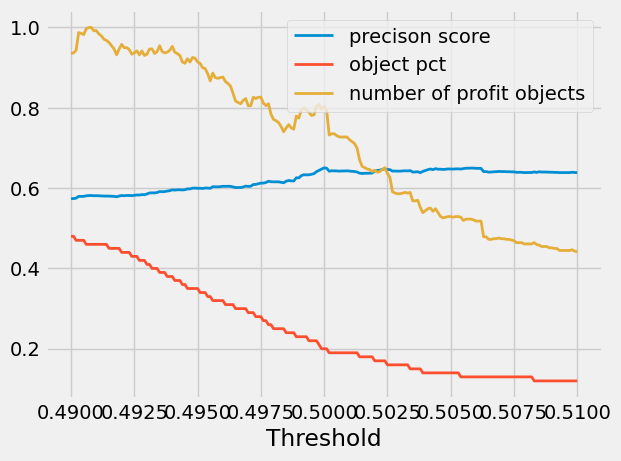

In [49]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.49, 0.51, 0.0001):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 4), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * prec_score - 1) * obj_num)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.49, 0.51, 0.0001), prec_score_list, label='precison score', linewidth=2)
    line2 = plt.plot(np.arange(0.49, 0.51, 0.0001), obj_pct_list, label='object pct', linewidth=2)
    line3 = plt.plot(np.arange(0.49, 0.51, 0.0001), obj_profit_list, label='number of profit objects', linewidth=2)
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [43]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])